In [16]:
import numpy as np
from scipy.constants import e, m_p, m_e, c, epsilon_0, m_n, k as kb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from cycler import cycler
from scipy.interpolate import interp1d
import glob, os
from scipy.odr import ODR, Model, RealData
from astropy.io import fits
from matplotlib import gridspec

plt.rcParams.update({
    # Color cycle
    "axes.prop_cycle": cycler('color', ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']),

    # Figure size
    "figure.figsize": (4, 3),

    # X ticks
    "xtick.direction": "in",
    "xtick.major.size": 3,
    "xtick.major.width": 0.5,
    "xtick.minor.size": 1.5,
    "xtick.minor.width": 0.5,
    "xtick.minor.visible": True,
    "xtick.top": True,

    # Y ticks
    "ytick.direction": "in",
    "ytick.major.size": 3,
    "ytick.major.width": 0.5,
    "ytick.minor.size": 1.5,
    "ytick.minor.width": 0.5,
    "ytick.minor.visible": True,
    "ytick.right": True,

    # Axes & lines
    "axes.linewidth": 0.5,
    "grid.linewidth": 0.5,
    "lines.linewidth": 1.0,

    # Font & math
    "font.family": "sans-serif",
    #"mathtext.fontset": "dejavuserif",
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}",

    # Legend & saving
    "legend.frameon": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05
})


In [71]:
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2570 / Axis length                                    
NAXIS2  =                 4611 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2006-03-20T14:56:47' / Date FITS file was generated                  
IRAF-TLM= '14:56:45 (20/03/2006)' / Time of last modification                   
OBJECT  = 'Lockman_mosaic_r_1046+5902 - DelRA =   0.0, DelDec =   0.0' / Name of
NEXTEND =                   

# Plotting the image

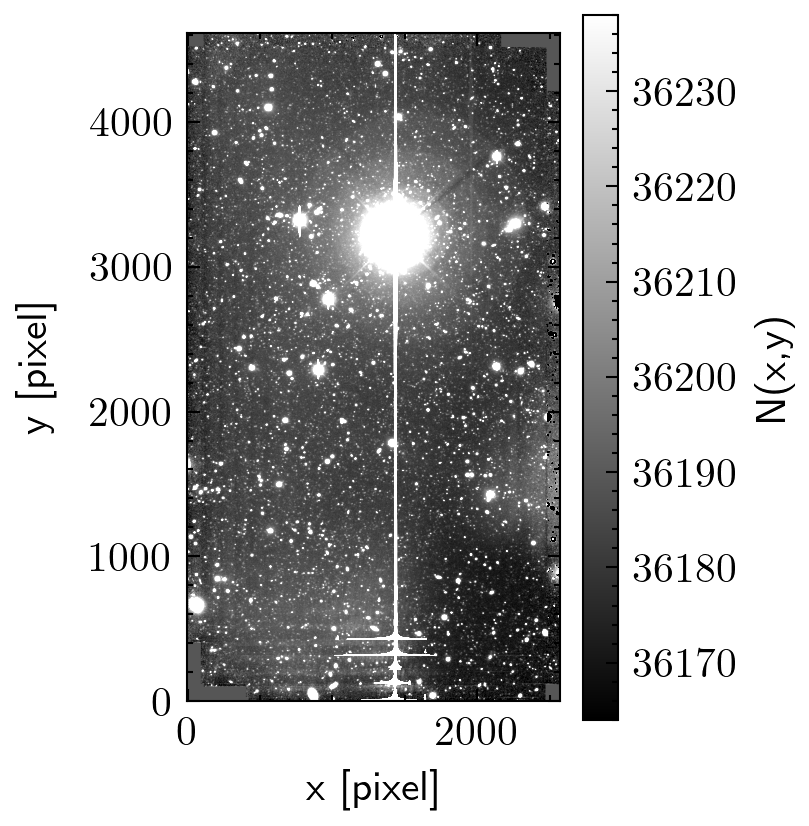

In [70]:
# Load the FITS file
with fits.open("data/Fits_Data/mosaic.fits") as hdul:
    image_data = hdul[0].data # this contains the count in each pixel
    header = hdul[0].header

# Apply scaling
# REAL = TAPE*BSCALE + BZERO                     
scaled_image = image_data * header.get('BSCALE', 1) + header.get('BZERO', 0)

# Get aspect ratio (width / height)
ny, nx = scaled_image.shape
aspect_ratio = nx / ny
enlarge = 1

# Plot
plt.figure(figsize=(5 * aspect_ratio * enlarge, 5 * enlarge), dpi=300)
plt.imshow(
    scaled_image,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(scaled_image, 5),
    vmax=np.percentile(scaled_image, 95)
)
plt.title('')
plt.colorbar(label='N(x,y)', shrink=0.5)
#plt.axis('off')
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()

# Examine the distribution in the count values

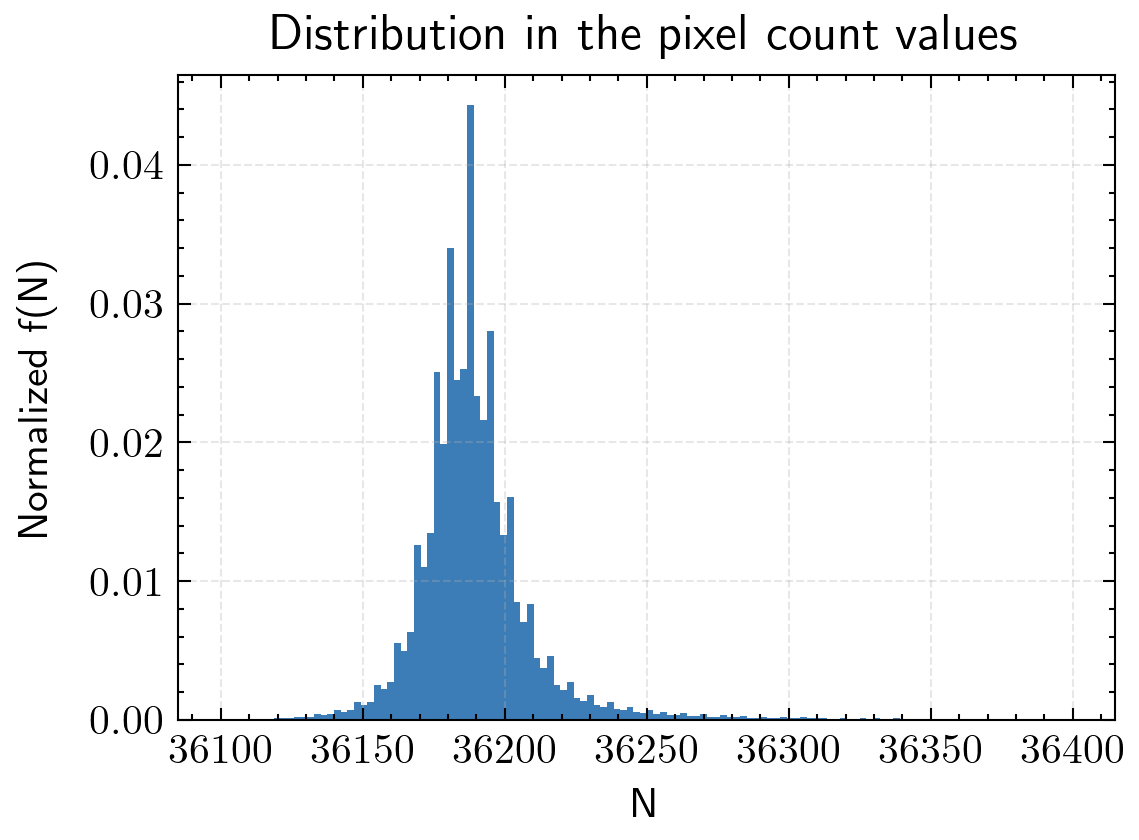

Mean: 36190.280
Std:  23.619


In [99]:
# Flatten to 1D array of counts
pixels = scaled_image.flatten()

# Define range
min_count, max_count = 36.1e3, 36.4e3

# Mask pixels within range
mask = (pixels >= min_count) & (pixels <= max_count)
pixels_in_range = pixels[mask]

# Compute mean and std within range
mean_val = np.mean(pixels_in_range)
std_val = np.std(pixels_in_range)

# Plot histogram
plt.figure(figsize=(4, 3), dpi=300)
plt.hist(pixels_in_range, bins=128, alpha=0.8, density=True, range=(min_count, max_count))
plt.xlabel('N')
plt.ylabel('Normalized f(N)', labelpad=8)
plt.title('Distribution in the pixel count values')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"Mean: {mean_val:.3f}")
print(f"Std:  {std_val:.3f}")


# Crop out a portion of the image to test code

Found 785 bright regions above 2σ


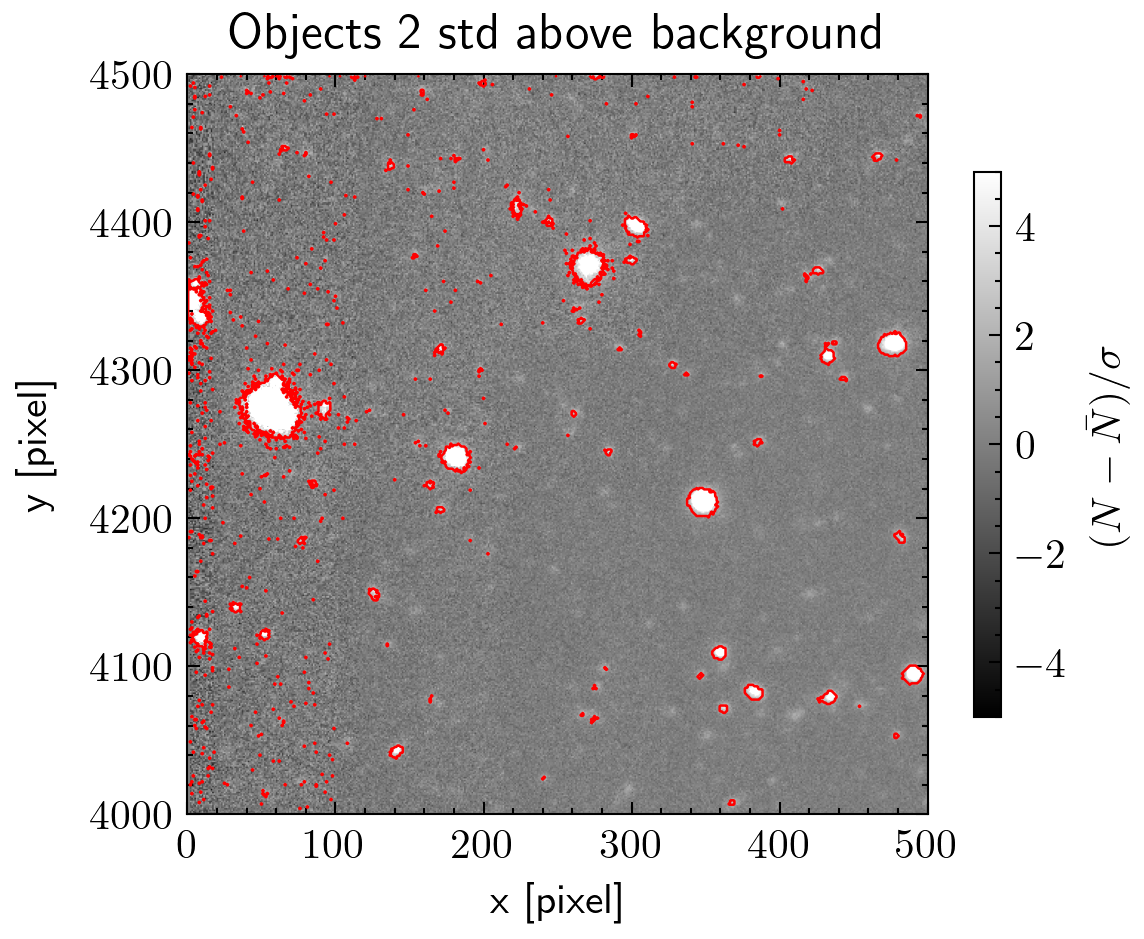

In [135]:
from scipy.ndimage import label, find_objects

mean = 36188.687
std = 27

# Subtract mean background
subtracted = scaled_image - mean

# Crop region
crop = subtracted[4000:4500, 0:500]/std

# Threshold: pixels > 2σ above background
threshold = 2
mask = crop > threshold

# Label connected bright regions
labeled, n_features = label(mask)
print(f"Found {n_features} bright regions above 2σ")

# Plot
plt.figure(figsize=(4, 4), dpi=300)
im = plt.imshow(
    crop,
    cmap='gray',
    origin='lower',
    vmin=-5,
    vmax=5,
    extent=[0, 500, 4000, 4500]
)

# Overlay red contours for bright regions
plt.contour(
    np.arange(0, 500),
    np.arange(4000, 4500),
    mask,
    levels=[0.5],
    colors='red',
    linewidths=0.6
)

plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.title('Objects 2 std above background')
plt.colorbar(im, label=r'$(N - \bar{N})/ \sigma$', shrink=0.5)
plt.tight_layout()
plt.show()


# I think go through this by starting from the top
# Make a circle

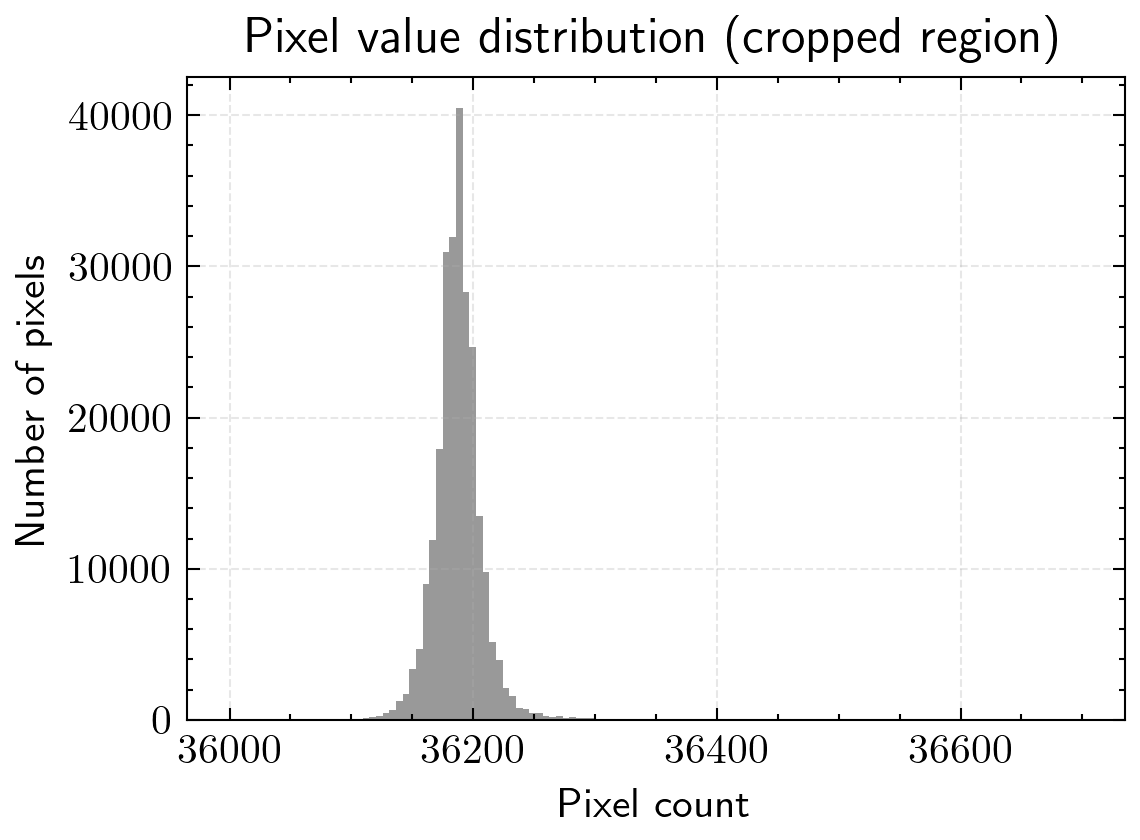

Mean (within range): 36188.687
Std (within range):  26.759


In [122]:
# Crop region (no subtraction)
crop = scaled_image[4000:4500, 0:500]

# Flatten into 1D for histogram
pixels_crop = crop.flatten()

# Define range
min_val, max_val = 36e3, 36.7e3

# Select pixels within the range
mask = (pixels_crop >= min_val) & (pixels_crop <= max_val)
pixels_in_range = pixels_crop[mask]

# Compute stats within that range
mean_val = np.mean(pixels_in_range)
std_val = np.std(pixels_in_range)

# Plot histogram
plt.figure(figsize=(4, 3), dpi=300)
plt.hist(pixels_in_range, bins=128, color='gray', alpha=0.8, range=(min_val, max_val))
plt.xlabel('Pixel count')
plt.ylabel('Number of pixels')
plt.title('Pixel value distribution (cropped region)')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"Mean (within range): {mean_val:.3f}")
print(f"Std (within range):  {std_val:.3f}")
